# Лабораторная работа №1 "Логистическая регрессия в качестве нейронной сети"

### Задание 1.
Загрузите данные и отобразите на экране несколько из изображений с помощью языка Python.


In [2]:
import warnings
warnings.filterwarnings('ignore')

from utils import get_dataset_by_url
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url_small = "https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz"
url_large = "https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz"

X_small, y_small = get_dataset_by_url(url_small)
X_large, y_large = get_dataset_by_url(url_large)

File already downloaded
Data already extracted
File already downloaded
Data already extracted


In [4]:
print(f"X small shape - {X_small.shape}")
print(f"y small shape - {y_small.shape}")

print(f"X large shape - {X_large.shape}")
print(f"y large shape - {y_large.shape}")

X small shape - (18724, 784)
y small shape - (18724,)
X large shape - (529114, 784)
y large shape - (529114,)


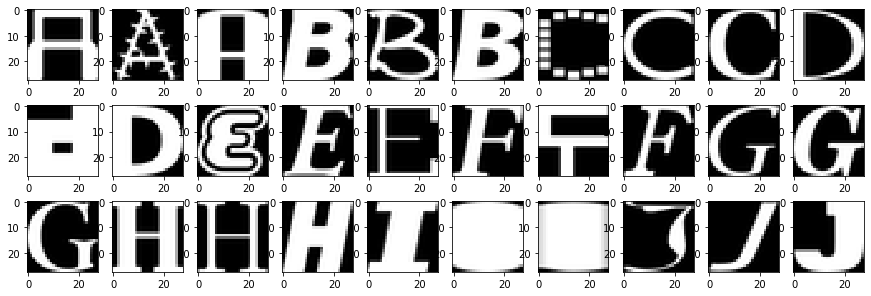

In [6]:
fig, ax = plt.subplots(3, 10, figsize=(15, 5))

cur = 0
step = len(y_small) // 29

for i in range(3):
    for j in range(10):
        img = X_small[cur]
        ax[i, j].imshow(img.reshape((28, 28)), cmap='gray')
        cur += step

plt.show()

### Задание 2.
Проверьте, что классы являются сбалансированными, т.е. количество изображений, принадлежащих каждому из классов, примерно одинаково (В данной задаче 10 классов).

In [7]:
from collections import Counter

In [8]:
Counter(y_small)

Counter({0: 1872,
         1: 1873,
         2: 1873,
         3: 1873,
         4: 1873,
         5: 1872,
         6: 1872,
         7: 1872,
         8: 1872,
         9: 1872})

In [9]:
Counter(y_large)

Counter({0: 52909,
         1: 52911,
         2: 52912,
         3: 52911,
         4: 52912,
         5: 52912,
         6: 52912,
         7: 52912,
         8: 52912,
         9: 52911})

Как видим, количество элементов в каждом классе для каждой выборке приблизительно одинаково.

### Задание 3.
Разделите данные на три подвыборки: обучающую (200 тыс. изображений), валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений).

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
TRAIN_SIZE = 200 * 1000
VALID_SIZE = 10 * 1000
TEST_SIZE = 19 * 1000

Сначала разделим выборку на тренировочную выборку из 200к изображений и на выборку, который впоследствии будет разделён на валидационную и тестовую выборку. Всю выборку предварительно перемешаем.

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X_large, y_large, train_size=TRAIN_SIZE, test_size=VALID_SIZE + TEST_SIZE, shuffle=True)

Затем промежуточную выборку разделим на валидационную и тестовую.

In [13]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=VALID_SIZE, test_size=TEST_SIZE, shuffle=True)

Теперь убедимся, что выборки разбиты приблизительно равными долями по отношению к классам.

In [14]:
Counter(y_train)

Counter({3: 19867,
         9: 20138,
         4: 20084,
         7: 20019,
         0: 19985,
         2: 19843,
         8: 19976,
         5: 20108,
         1: 20010,
         6: 19970})

In [15]:
Counter(y_valid)

Counter({2: 1036,
         3: 1023,
         7: 996,
         9: 997,
         0: 983,
         1: 1002,
         8: 1013,
         6: 1025,
         4: 940,
         5: 985})

In [16]:
Counter(y_test)

Counter({6: 1905,
         4: 1822,
         8: 1873,
         9: 1875,
         5: 1942,
         1: 1861,
         2: 1940,
         7: 1896,
         3: 1974,
         0: 1912})

### Задание 4.
Проверьте, что данные из обучающей выборки не пересекаются с данными из валидационной и контрольной выборок. Другими словами, избавьтесь от дубликатов в обучающей выборке.

Подход следующий: захешируем все элементы выборок с помощью алгоритма md5, чтобы ускорить сравнение. Затем с помощью функции `intersect1d` найдём индексы одинаковых элементов в тренировочной и валидационной выборке и удалим дубликаты из тренировочной. Далее с помощью той же функции найдём дубликаты в тренировочной и тестовой выборке и также удалим. Посчитаем процент удалённых дубликатов.

In [17]:
import hashlib

def remove_duplicates(X1, y1, X2, X3):
    X1_hash = np.array([hashlib.md5(x).hexdigest() for x in X1])
    X2_hash = np.array([hashlib.md5(x).hexdigest() for x in X2])
    X3_hash = np.array([hashlib.md5(x).hexdigest() for x in X3])
    
    init_len = len(X1_hash)
    _, x1_ind, _ = np.intersect1d(X1_hash, X2_hash, return_indices=True)
    new_X1 = np.delete(X1, x1_ind, 0)
    new_X1_hash = np.delete(X1_hash, x1_ind, None)
    new_y1 = np.delete(y1, x1_ind, None)

    _, x1_ind, _ = np.intersect1d(new_X1_hash, X3_hash, return_indices=True)
    X_clean = np.delete(new_X1, x1_ind, 0)
    y_clean = np.delete(new_y1, x1_ind, None)
    final_len = len(X_clean)
    cleaned_percentage = round((init_len - final_len) / init_len, 4)
    print(f"Removed {cleaned_percentage * 100}%")
    return X_clean, y_clean

In [18]:
X_train_clean, y_train_clean = remove_duplicates(X_train, y_train, X_valid, X_test)
print(f"New X_train size: {len(X_train_clean)}")

Removed 1.39%
New X_train size: 197213


### Задание 5.
Постройте простейший классификатор (например, с помощью логистической регрессии). Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000).
Для построения классификатора можете использовать библиотеку SkLearn (http://scikit-learn.org).

In [19]:
from sklearn.linear_model import LogisticRegression

Построим классификатор с помощью логистической регресии. Классификатор строится по принципу "один против всех" (one-vs-rest).

С помощью валидационной выборки выбирается наилучший параметр регуляризации при котором достигается наибольшая точность для заданного размера обучающей выборки.

Затем для наилучшей модели вычисляется точность на контрольной выборке.

In [20]:
def calculate_scores(size_options):
    scores = {}

    for size in size_options:
        model = find_best_model(X_train_clean[:size], y_train_clean[:size])
        test_score = model.score(X_test, y_test)
        scores[size] = test_score
        
    return scores

In [21]:
def find_best_model(X, y):
    cur_score = 0
    best_model = None
    C_param_list = [0.01, 0.03, 0.1, 0.3, 1]

    for C_param in C_param_list:
        model = LogisticRegression(multi_class='ovr', max_iter=1000, C=C_param).fit(X, y)
        score = model.score(X_valid, y_valid)
        if score > cur_score:
            cur_score = score
            best_model = model
            
    return best_model

In [22]:
scores = calculate_scores([50, 100, 1000, 50000])
scores

{50: 0.5508947368421052,
 100: 0.6521578947368422,
 1000: 0.8005263157894736,
 50000: 0.8245789473684211}

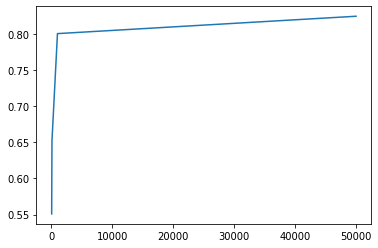

In [23]:
plt.plot(list(scores.keys()), list(scores.values()))
plt.show()

График показывает зависимость значения точности от размера обучающей выборки. Как видим, чем больше обучающая выборка, тем большей точности удаётся достичь. Однако важно заметить, что чем больше размер выборки, тем меньше становится прирост точности, т.е. существует некий порог, который значение точности классификатора превзойти не сможет.